In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxx"

In [2]:
!kaggle competitions download planet-understanding-the-amazon-from-space -f train-jpg.tar.7z

 99% 597M/600M [00:07<00:00, 38.1MB/s]
100% 600M/600M [00:07<00:00, 85.2MB/s]


In [4]:
!kaggle competitions download planet-understanding-the-amazon-from-space -f train-jpg.tar.7z

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!kaggle competitions download planet-understanding-the-amazon-from-space -f train_v2.csv.zip

  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 49.4MB/s]


In [6]:
!7z x train-jpg.tar.7z
!tar -xvf train-jpg.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: train-jpg.tar.7z
--
Path = train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg.tar    

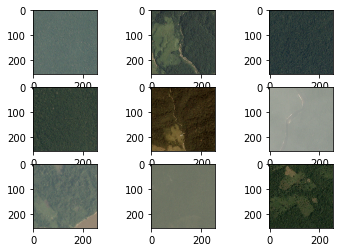

In [0]:
# plot the first 9 images in the planet dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train-jpg/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [7]:
!unzip train_v2.csv.zip

Archive:  train_v2.csv.zip
  inflating: train_v2.csv            
   creating: __MACOSX/
  inflating: __MACOSX/._train_v2.csv  


In [0]:
# load and summarize the mapping file for the planet dataset
from pandas import read_csv
# load file as CSV
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# summarize properties
print(mapping_csv.shape)
print(mapping_csv[:10])

(40479, 2)
  image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road


In [0]:
# create a mapping of tags to integers
from pandas import read_csv

# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# load file as CSV
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
mapping, inv_mapping = create_tag_mapping(mapping_csv)
print(len(mapping))
print(mapping)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [8]:
# load and prepare planet dataset and save to file
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# create a mapping of filename to a list of tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

# create a one hot encoding for one list of tags
def one_hot_encode(tags, mapping):
	# create empty vector
	encoding = zeros(len(mapping), dtype='uint8')
	# mark 1 for each tag in the vector
	for tag in tags:
		encoding[mapping[tag]] = 1
	return encoding

# load all images into memory
def load_dataset(path, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in listdir(folder):
		# load image
		photo = load_img(path + filename, target_size=(128,128))
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

# load the mapping file
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)
# load the jpeg images
folder = 'train-jpg/'
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)
# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

Using TensorFlow backend.


(40479, 128, 128, 3) (40479, 17)


In [0]:
# test f-beta score
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# load dataset
trainX, trainY, testX, testY = load_dataset()
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
All Ones: train=0.484, test=0.483


In [0]:
# compare f-beta score between sklearn and keras
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras import backend

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# load dataset
trainX, trainY, testX, testY = load_dataset()
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions with sklearn
train_score = fbeta_score(trainY, train_yhat, 2, average='samples')
test_score = fbeta_score(testY, test_yhat, 2, average='samples')
print('All Ones (sklearn): train=%.3f, test=%.3f' % (train_score, test_score))
# evaluate predictions with keras
train_score = fbeta(backend.variable(trainY), backend.variable(train_yhat)).eval(session=backend.get_session())
test_score = fbeta(backend.variable(testY), backend.variable(test_yhat)).eval(session=backend.get_session())
print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0817 12:47:09.023957 140277631776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0817 12:47:09.025237 140277631776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0817 12:47:09.026113 140277631776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



All Ones (sklearn): train=0.484, test=0.483


W0817 12:47:10.342225 140277631776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0817 12:47:10.343482 140277631776640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



All Ones (keras): train=0.484, test=0.483


In [0]:
# baseline model for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0817 13:00:56.330650 140567390746496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 13:00:56.366312 140567390746496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 13:00:56.373662 140567390746496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 13:00:56.425276 140567390746496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 13:00:56.520256 140567390746496 deprecation_wrapp

> loss=0.446, fbeta=0.827


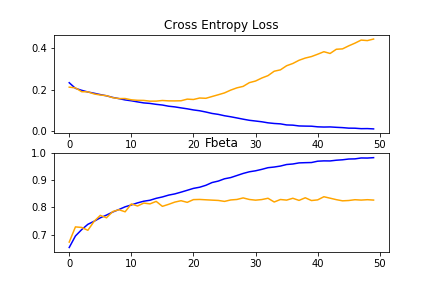

In [0]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")

In [0]:
# baseline model with dropout on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0817 13:38:18.693665 140567390746496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")

In [0]:
# baseline model with data augmentation for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=128)
	test_it = test_datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

In [0]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")

In [0]:
# vgg16 transfer learning on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

In [0]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")

In [3]:
# vgg16 transfer learning on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=128)
	test_it = datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                                validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Using TensorFlow backend.


(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


W0818 09:44:53.612455 140195877955456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 09:44:53.642964 140195877955456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 09:44:53.649430 140195877955456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 09:44:53.696636 140195877955456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0818 09:44:54.204057 140195877955456 deprecation_wrapp

> loss=0.205, fbeta=0.883


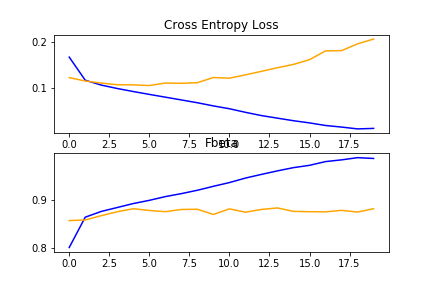

In [4]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")

In [0]:
# vgg with fine-tuning and data augmentation for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	train_datagen.mean = [123.68, 116.779, 103.939]
	test_datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=128)
	test_it = test_datagen.flow(testX, testY, batch_size=128)
	# define model
	model = define_model()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


In [0]:
from IPython.display import Image
Image("ipykernel_launcher.py_plot.png")